## Read and plot Millstone Hill IS radar data.
P. Erickson
2025-07-25

In [1]:
import h5py
import pylab
import datetime
import dateutil.parser
import calendar
import numpy

In [2]:
def read_file(fname, kinst=32, elrange=[85,90], pulf=[400e-6,1000e-6]):

    # read HDF5 file
    hz = h5py.File(fname,'r')
    hztl = hz['Data']['Table Layout']
    
    # filter by desired kinst, pulse length
    indx = numpy.where(hztl['kinst'] == kinst)[0]
    hztl = hztl[indx]
    indx = numpy.where(hztl['pulf'] > pulf[0])[0]  # choose either coded or uncoded pulse
    hztl = hztl[indx]
    indx = numpy.where(hztl['pulf'] < pulf[1])[0]  # choose either coded or uncoded pulse
    hztl = hztl[indx]
    indx = numpy.where(hztl['el1'] > elrange[0])[0]  # choose either coded or uncoded pulse
    hztl = hztl[indx]
    indx = numpy.where(hztl['el1'] < elrange[1])[0]  # choose either coded or uncoded pulse
    hztl = hztl[indx]
    
                           
    # Unix time and datetime objects
    ut = 0.5*(hztl['ut1_unix'] + hztl['ut2_unix'])
    dut = numpy.array([datetime.datetime.utcfromtimestamp(uut) for uut in ut])

    # 
    # 1D time, altitude, range arrays
    #
    
    tcount = len(set(list(ut)))
    rcount = len(hztl)/tcount
    tuniq = numpy.array(list(set(ut)))
    tuniq.sort()
    dtuniq = numpy.array([datetime.datetime.utcfromtimestamp(uut) for uut in tuniq])
    runiq = numpy.array(list(set(hztl['range'])))
    runiq.sort()
    auniq = numpy.array(list(set(hztl['gdalt'])))
    auniq.sort()
    
    return tuniq, dtuniq, runiq, auniq, hztl

# Madrigal variables: "pulf" = fundamental pulse length (after decompression.) 480 usec for uncoded pulse, 30 usec for coded pulse. "kinst" = 32 for zenith antenna, 31 for steerable (MISA) antenna

In [3]:
def plot_data(dtuniq, runiq, hztl, fname, kinst,
            min_alt=180, max_alt=500, 
            ne_min=1e11, ne_max=1e12,
            te_min=500, te_max=4000,
            ti_min=500, ti_max=2500,
            vo_min=-100, vo_max=100,
            pfreq_min=1, pfreq_max=9,
            stime=None, etime=None):

    # time select if desired
    if stime == None:
        dstime = dtuniq[0]
    else:
        dstime = stime
    if etime == None:
        detime = dtuniq[-1]
    else:
        detime = etime
    
    # make summary plots

    pulf = 1e6*list(set(hztl['pulf']))[0] # for labeling
    elangle = list(set(hztl['el1']))[0] # for labeling
    titlestr = fname + ' KINST=%i PULF=%s EL=%.1f' % (kinst, pulf, elangle)
    
    # output filename
    fnameprefix = fname.split('.')[0] + '_%i_%i_%i' % (kinst, pulf, int(elangle)) # for labeling

    # signal to noise
    X, Y = numpy.meshgrid(runiq, dtuniq)
    Z = numpy.log10(hztl['sn'])
    Z = Z.reshape(X.shape)
    pylab.figure(figsize=(8,8))
    pylab.pcolor(Y, X, Z, vmin=-1, vmax=1, cmap='plasma')
    yl = pylab.ylim()
    pylab.ylim(min_alt,max_alt)
    pylab.xlim(dstime, detime)
    pylab.colorbar(label='log10(SNR)')
    pylab.ylabel('Altitude (km)')
    pylab.xlabel('UT (Hours)')
    pylab.gcf().autofmt_xdate()
    pylab.title(titlestr)
    pylab.savefig(fnameprefix + '_sn.png',dpi=300)

    # uncorrected electron density
    Z = hztl['popl']
    Z = Z.reshape(X.shape)
    pylab.figure(figsize=(8,8))
    pylab.pcolor(Y, X, Z, vmin=10.5, vmax=12, cmap='plasma')
    yl = pylab.ylim()
    pylab.ylim(min_alt,max_alt)
    pylab.xlim(dstime, detime)
    pylab.colorbar(label='Uncorrected Electron Density (POPL)')
    pylab.ylabel('Altitude (km)')
    pylab.xlabel('UT (Hours)')
    pylab.gcf().autofmt_xdate()
    pylab.title(titlestr)
    pylab.savefig(fnameprefix + '_popl.png',dpi=300)

    # linear electron density from full fit
    Z = hztl['ne']
    Z = Z.reshape(X.shape)
    pylab.figure(figsize=(8,8))
    pylab.pcolor(Y, X, Z, vmin=ne_min, vmax=ne_max, cmap='plasma')
    yl = pylab.ylim()
    pylab.ylim(min_alt,max_alt)
    pylab.xlim(dstime, detime)
    pylab.colorbar(label='[e-],m^-3')
    pylab.ylabel('Altitude (km)')
    pylab.xlabel('UT (Hours)')
    pylab.gcf().autofmt_xdate()
    pylab.title(titlestr)
    pylab.savefig(fnameprefix + '_ne.png',dpi=300)
    
    # effective plasma frequency
    Z = hztl['ne']
    Z = Z/1e12
    Z = 8.98*numpy.sqrt(Z)
    Z = Z.reshape(X.shape)
    pylab.figure(figsize=(8,8))
    pylab.pcolor(Y, X, Z, vmin=pfreq_min, vmax=pfreq_max, cmap='plasma')
    yl = pylab.ylim()
    pylab.ylim(min_alt,max_alt)
    pylab.xlim(dstime, detime)
    pylab.colorbar(label='Plasma Freq from Ion Line Density, MHz')
    pylab.ylabel('Altitude (km)')
    pylab.xlabel('UT (Hours)')
    pylab.gcf().autofmt_xdate()
    pylab.title(titlestr)
    pylab.savefig(fnameprefix + '_pfreq.png',dpi=300)

    # log electron density from full fit
    Z = numpy.log10(hztl['ne'])
    Z = Z.reshape(X.shape)
    pylab.figure(figsize=(8,8))
    pylab.pcolor(Y, X, Z, vmin=numpy.log10(ne_min), vmax=numpy.log10(ne_max), cmap='plasma')
    yl = pylab.ylim()
    pylab.ylim(min_alt,max_alt)
    pylab.xlim(dstime, detime)
    pylab.colorbar(label='log10([e-],m^-3)')
    pylab.ylabel('Altitude (km)')
    pylab.xlabel('UT (Hours)')
    pylab.gcf().autofmt_xdate()
    pylab.title(titlestr)
    pylab.savefig(fnameprefix + '_nel.png',dpi=300)
        
    # ion temperature
    Z = hztl['ti']
    Z = Z.reshape(X.shape)
    pylab.figure(figsize=(8,8))
    pylab.pcolor(Y, X, Z, vmin=ti_min, vmax=ti_max, cmap='plasma')
    yl = pylab.ylim()
    pylab.ylim(min_alt,max_alt)
    pylab.xlim(dstime, detime)
    pylab.colorbar(label='Ti')
    pylab.ylabel('Altitude (km)')
    pylab.xlabel('UT (Hours)')
    pylab.gcf().autofmt_xdate()    
    pylab.title(titlestr)
    pylab.savefig(fnameprefix + '_ti.png',dpi=300)
    
    # electron temperature
    Z = hztl['ti']*hztl['tr']
    Z = Z.reshape(X.shape)
    pylab.figure(figsize=(8,8))
    pylab.pcolor(Y, X, Z, vmin=te_min, vmax=te_max, cmap='plasma')
    yl = pylab.ylim()
    pylab.ylim(min_alt,max_alt)
    pylab.xlim(dstime, detime)
    pylab.colorbar(label='Te')
    pylab.ylabel('Altitude (km)')
    pylab.xlabel('UT (Hours)')
    pylab.gcf().autofmt_xdate()    
    pylab.title(titlestr)
    pylab.savefig(fnameprefix + '_te.png',dpi=300)

    # line of sight velocity
    Z = hztl['vo']
    Z = Z.reshape(X.shape)
    pylab.figure(figsize=(8,8))
    pylab.pcolor(Y, X, Z, vmin=vo_min, vmax=vo_max, cmap='bwr')
    yl = pylab.ylim()
    pylab.ylim(min_alt,max_alt)
    pylab.xlim(dstime, detime)
    pylab.colorbar(label='Line-of-sight Velocity')
    pylab.ylabel('Altitude (km)')
    pylab.xlabel('UT (Hours)')
    pylab.gcf().autofmt_xdate()    
    pylab.title(titlestr)
    pylab.savefig(fnameprefix + '_vo.png',dpi=300)

In [4]:
def make_plots(fname, kinst, pulf, elrange):
    # Make plot routine: read file, plot it
    tuniq, dtuniq, runiq, auniq, hz = read_file(fname, kinst, elrange, pulf)
    plot_data(dtuniq, runiq, hz, fname, kinst,
              min_alt=180, max_alt=600,
              ne_min=1e11, ne_max=1e12,
              te_min=500, te_max=3500,
              ti_min=800, ti_max=2000,
              vo_min=-100, vo_max=100,
              pfreq_min=1, pfreq_max=7)

### NB: use zenith data only for this experiment.  MISA data is complicated because altitude array values 'wiggle around' in last digit, making construction of 1D altitude array complicated.

### Plot 480 usec uncoded pulse

/var/folders/fv/q7qf8rjn6zdd37k3vttxspjw0000gp/T/ipykernel_23488/441492394.py:31: RuntimeWarning: divide by zero encountered in log10
  Z = numpy.log10(hztl['sn'])
/var/folders/fv/q7qf8rjn6zdd37k3vttxspjw0000gp/T/ipykernel_23488/441492394.py:31: RuntimeWarning: invalid value encountered in log10
  Z = numpy.log10(hztl['sn'])


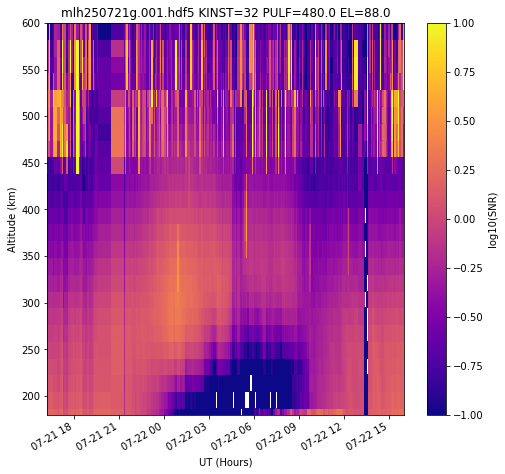

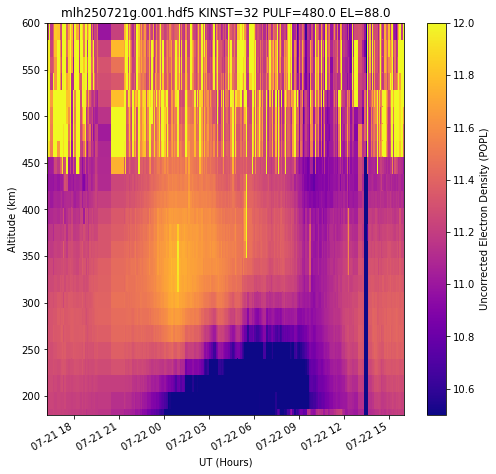

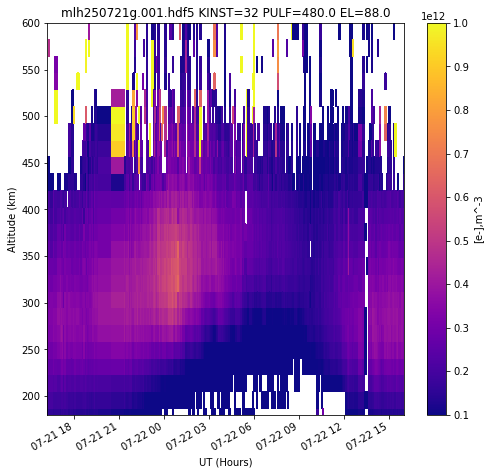

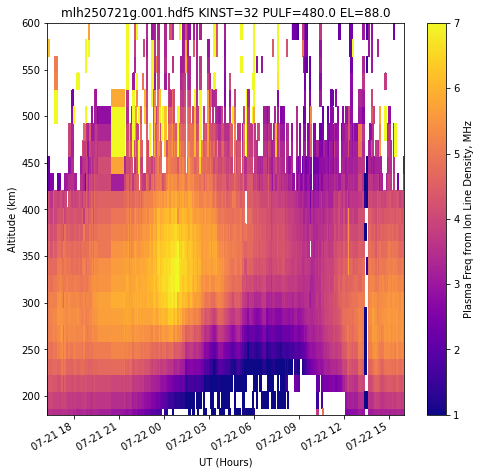

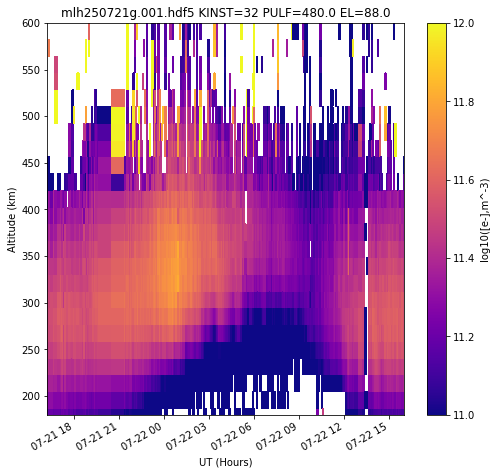

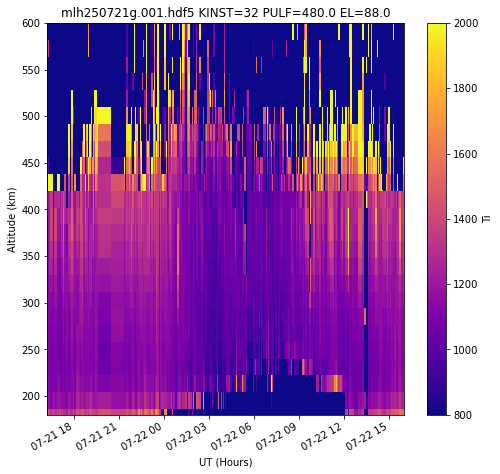

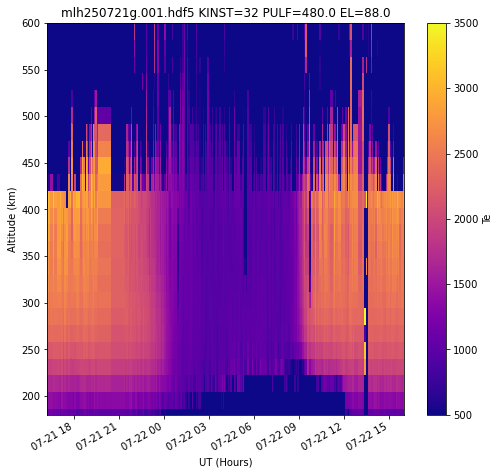

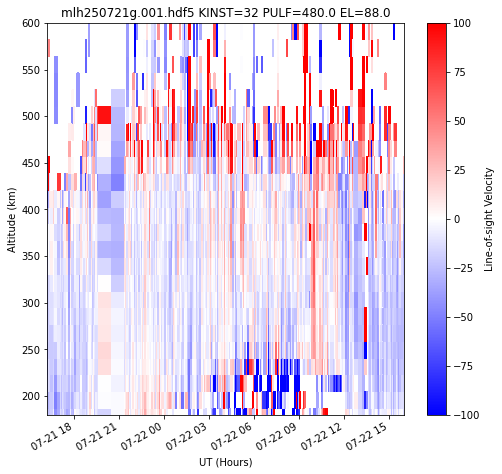

In [5]:
fname = 'mlh250721g.001.hdf5'
kinst = 32 # 31 = MISA, 32 = zenith
pulf = [400e-6,1000e-6] # select uncoded pulse
elrange = [85,90] # elevation angle filter
make_plots(fname, kinst, pulf, elrange)

### Plot alternating code data (30 usec effective pulse length)

/var/folders/fv/q7qf8rjn6zdd37k3vttxspjw0000gp/T/ipykernel_23488/441492394.py:31: RuntimeWarning: divide by zero encountered in log10
  Z = numpy.log10(hztl['sn'])
/var/folders/fv/q7qf8rjn6zdd37k3vttxspjw0000gp/T/ipykernel_23488/441492394.py:31: RuntimeWarning: invalid value encountered in log10
  Z = numpy.log10(hztl['sn'])


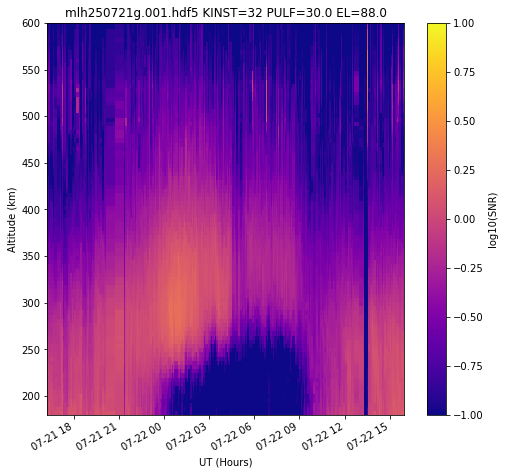

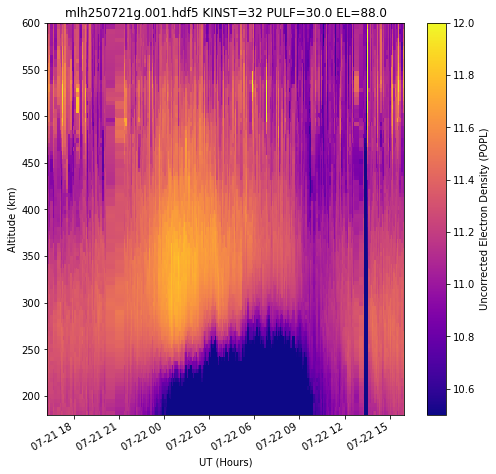

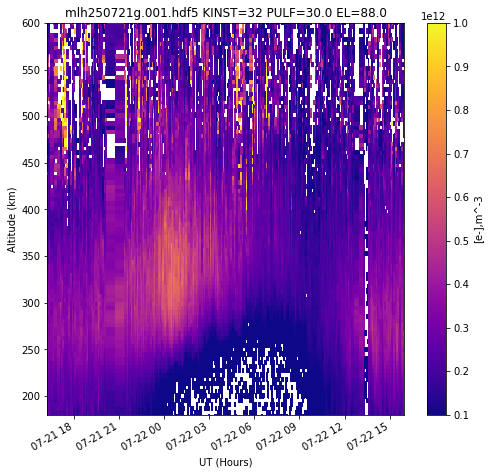

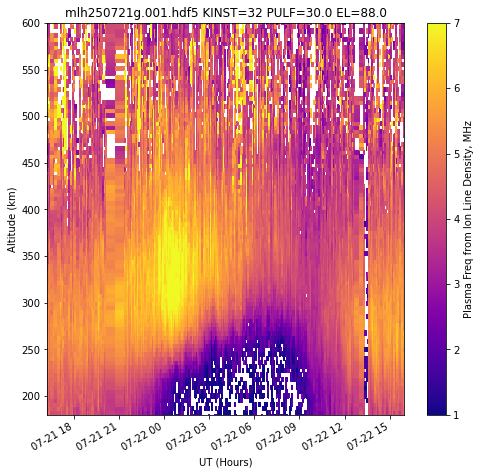

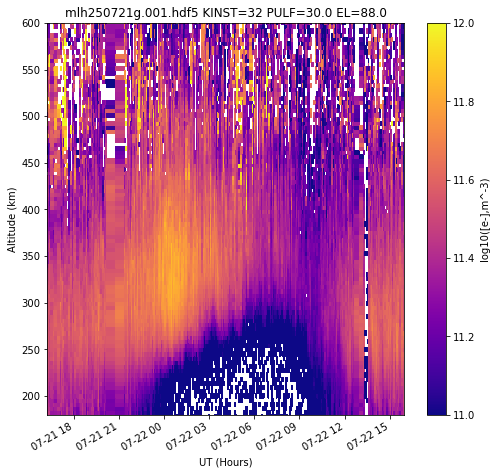

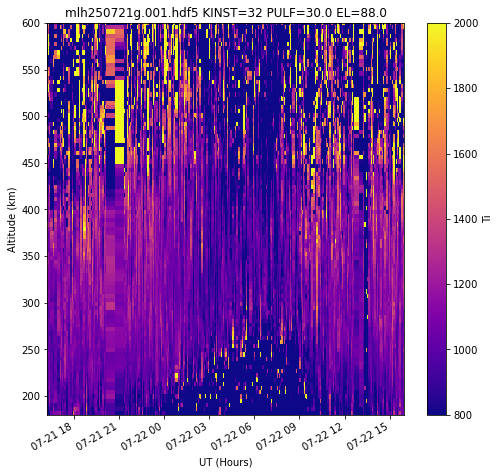

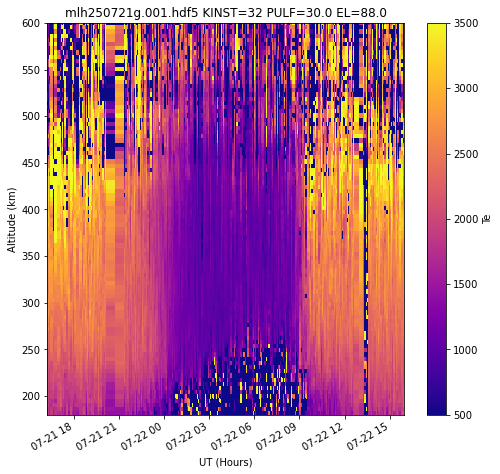

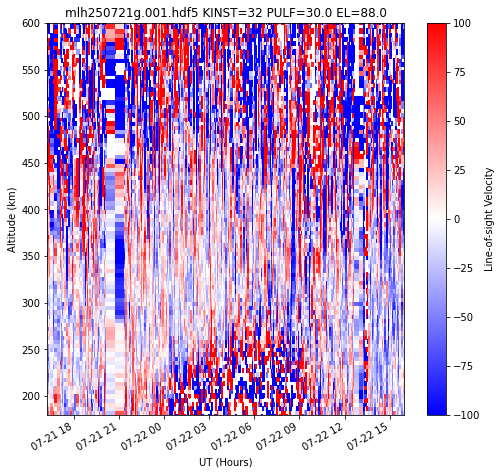

In [6]:
fname = 'mlh250721g.001.hdf5'
kinst = 32 # 31 = MISA, 32 = zenith
pulf = [10e-6,400e-6] # select coded pulse
elrange = [85,90] # elevation angle filter
make_plots(fname, kinst, pulf, elrange)